# 12 Clipping

In this lesson we will learn how to to clip different geometries.

## About the data

We will use three datasets in this lesson. 

The first dataset is a [TIGER shapefile of the US states from the United States Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-790442341). Follow these steps to download shapefile with the United States' states:

You can check the [metadata for all the TIGER shapefiles here](https://www.census.gov/programs-surveys/geography/technical-documentation/complete-technical-documentation/tiger-geo-line.html). 

The second dataset we'll use is [Natural Earth's simple medium scale populated places dataset](https://www.naturalearthdata.com/downloads/50m-cultural-vectors/). We can obtain this dataset by downloading the shapefile (choose the one that says "simple (less columns)").

The third dataset we'll use is [Natural Earth's road dataset](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/roads/). 
We can obtain this dataset by downloading the shapefile 

We will combine these datasets to create the following map of infrastructure in Alaska:

## Import data

Let's start by loading our libraries and then importing the datasets we will use.


In [1]:
# import pyproj
# print(pyproj.datadir.get_data_dir())

# import os
# os.environ['PROJ_LIB'] = '/opt/anaconda3/envs/eds220-env/share/proj'

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

from shapely.geometry import box  # To create polygon bounding box


pd.set_option("display.max.columns", None)

# -------------------------------------------------------
# Import and simplify states polygons
states = gpd.read_file(os.path.join('data', 
                                    'tl_2022_us_state', 
                                    'tl_2022_us_state.shp'))

# Import Natural Earth populated places points
places = gpd.read_file(os.path.join('data',
                                    'ne_50m_populated_places_simple',
                                    'ne_50m_populated_places_simple.shp')
                                    )

# Import ferry routes lines
roads = gpd.read_file(os.path.join('data',
                                   'ne_10m_roads',
                                   'ne_10m_roads.shp')
                                   )

## Check-in
Use a for loop to iterate over the three geo-dataframes we imported and change their column names to lower caps.

In [3]:
# Define list of data frames
gdfs = [states, places, roads]

# Wrtie for loop to iterate over the gdfs
for gdf in gdfs:
    gdf.columns = gdf.columns.str.lower()
    #print(gdf.columns)

## Prepare Alaska multipolygon

Let’s start by taking taking a look at our `states` geo-dataframe. Since this is a geospatial dataset, exploration should include at least checking the head of the dataset, plotting the data, and looking at its CRS.

In [4]:
print(f"CRS: {states.crs}")

states.head(3)

CRS: EPSG:4269


,region,division,statefp,statens,geoid,stusps,name,lsad,mtfcc,funcstat,aland,awater,intptlat,intptlon,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266456923,489045863,+38.6472854,-080.6183274,"POLYGON ((-77.75438 39.33346, -77.75422 39.333..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138962819934,45971472526,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143778515726,6216539665,+40.1028754,-089.1526108,"POLYGON ((-87.89243 38.28285, -87.89334 38.282..."


<Axes: >

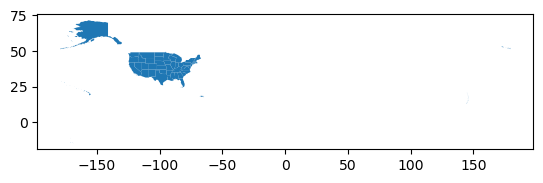

In [5]:
states.plot()

<Axes: >

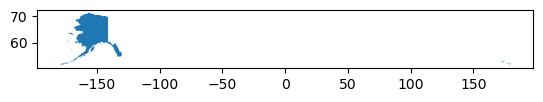

In [6]:
# Select only alaska data
alaska = states[states.name =='Alaska']
alaska.plot()

Notice that the way the Alaska multipolygon is plotted under the NAD83/EPSG:4269 CRS separates the islands and unnaturally elongates the map. To fix this, we will reproject the Alaska geo-dataframe to the EPSG:3338 CRS. This CRS is a projected CRS, better suited for working with data from Alaska:
![](epsg_3338.png)

Source: [spatialreference.org](spatialreference.org)


In [7]:
# Reproject to CRS optimized for Alaska
alaska = alaska.to_crs('epsg:3338')

# Inspect the new CRS
print('Is this CRS projected? ', alaska.crs.is_projected)
alaska.crs

Is this CRS projected?  True


<Projected CRS: EPSG:3338>
Name: NAD83 / Alaska Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Alaska.
- bounds: (172.42, 51.3, -129.99, 71.4)
Coordinate Operation:
- name: Alaska Albers (meter)
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Axes: >

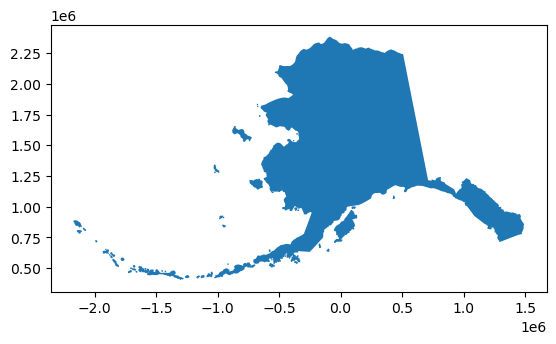

In [8]:
alaska.plot()

## Prepare populated places points
Let's now explore the populated places data

In [9]:
print(f"CRS: {places.crs}")

places.head(3)

CRS: EPSG:4326


,scalerank,natscale,labelrank,featurecla,name,namepar,namealt,nameascii,adm0cap,capalt,capin,worldcity,megacity,sov0name,sov_a3,adm0name,adm0_a3,adm1name,iso_a2,note,latitude,longitude,pop_max,pop_min,pop_other,rank_max,rank_min,meganame,ls_name,min_zoom,ne_id,geometry
0,10,1,5,Admin-1 region capital,Bombo,None,None,Bombo,0,0,None,0,0,Uganda,UGA,Uganda,UGA,Bamunanika,UG,None,0.583299,32.533300,75000,21000,0.0,8,7,None,None,7.0,1159113923,POINT (32.53330 0.58330)
1,10,1,5,Admin-1 region capital,Fort Portal,None,None,Fort Portal,0,0,None,0,0,Uganda,UGA,Uganda,UGA,Kabarole,UG,None,0.671004,30.275002,42670,42670,0.0,7,7,None,None,7.0,1159113959,POINT (30.27500 0.67100)
2,10,1,3,Admin-1 region capital,Potenza,None,None,Potenza,0,0,None,0,0,Italy,ITA,Italy,ITA,Basilicata,IT,None,40.642002,15.798997,69060,69060,0.0,8,8,None,None,7.0,1159117259,POINT (15.79900 40.64200)


<Axes: >

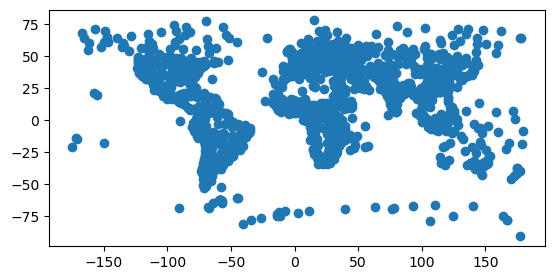

In [10]:
places.plot()

This dataset has the EPSG:4326 CRS. Remember this is the EPSG code for the WGS 84 CRS. This is not a surprise since the places data is global and EPSG:4326/WGS84 is the most widely used CRS for such data.

Let’s see what happens when we try to plot this data on top of Alaska:

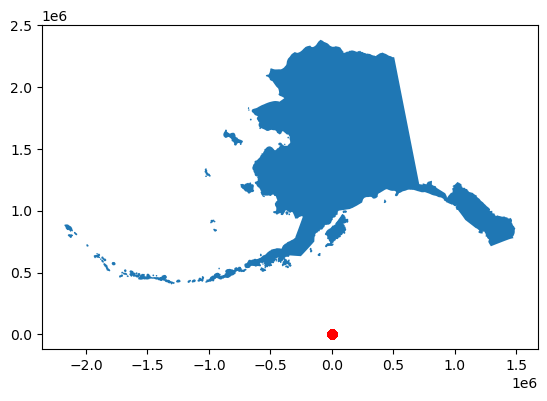

In [11]:
# Trouble
fig, ax = plt.subplots()

alaska.plot(ax=ax)
places.plot(ax=ax, color='red')

plt.show()

This is a classic slip in geospatial analysis. To plot, analyze, or integrate different geospatial datasets they **must have the same CRS**.

Here, `alaska` and `places` have different CRSs, leading to unexpected results when plotting them together:

In [12]:
alaska.crs == places.crs

False

Lets check that map again

## Check-in 
Reproject the `places` geo-dataframe into `alaska`'s CRS and verify the CRSs match using assert.'


In [13]:
places = places.to_crs(alaska.crs)

assert alaska.crs == places.crs

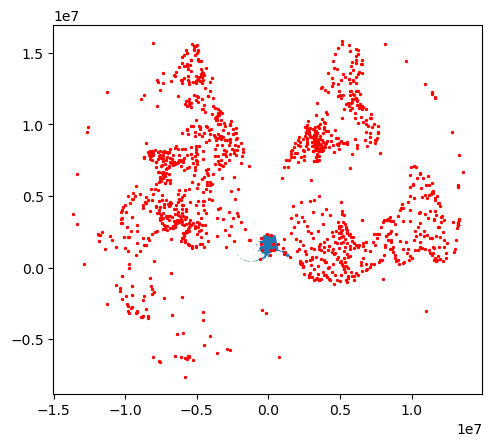

In [14]:
fig, ax = plt.subplots()

alaska.plot(ax=ax)
places.plot(ax=ax, color='red', markersize=2)

plt.show()

This is better: we can see there the Alaska poygons and some of the `places` points on top of it. Our next step is to select these points.

## Clipping

**Clipping** means using a polygon (or polygons) to only select geospatial data within them. Clipping a `geopandas.GeoDataFrame` is simple using the geopandas *clip() function*. The general syntax is:

`updated_geodf = geopandas.clip(geodf, mask)`

where:

- `updated_geodf` is the output of the method: the intersection of the geometries in `geodf` with mask,
- `geodf` is the` geopandas.GeoDataFrame` we want to clip,
- `mask` is a `geopandas.GeoDataFrame` with the polygon(s) we want to use for clipping. This mask must be in the same CRS as `geodf`!

In our case:

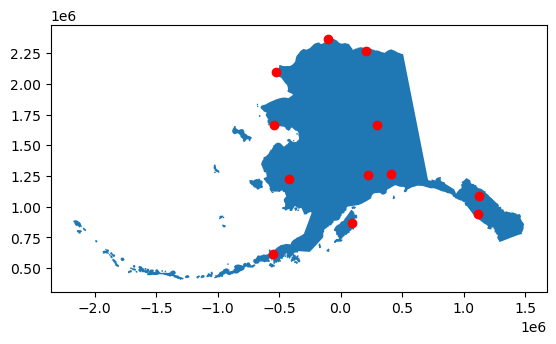

In [15]:
# Clip populated places to Alaska multipolygon
ak_places = gpd.clip(places, alaska)

fig, ax = plt.subplots()
alaska.plot(ax=ax)
ak_places.plot(ax=ax, color='red')
plt.show()

## Prepare roads
Now we move on to our roads dataset

In [16]:
print(roads.crs)

roads.head(3)

EPSG:4326


,scalerank,featurecla,type,sov_a3,note,edited,name,namealt,namealtt,routeraw,question,length_km,toll,ne_part,label,label2,local,localtype,localalt,labelrank,ignore,add,rwdb_rd_id,orig_fid,prefix,uident,continent,expressway,level,min_zoom,min_label,geometry
0,8,Road,Secondary Highway,CAN,None,"Version 1.5: Changed alignment, a few adds in ...",None,None,None,None,0,3,0,ne_1d4_original,None,None,None,None,None,0,0,0,0,0,None,314705,North America,0,None,7.1,9.6,"LINESTRING (-133.32533 62.21571, -133.31664 62..."
1,7,Road,Secondary Highway,USA,None,"Version 1.5: Changed alignment, a few adds in ...",83,None,None,None,0,164,0,ne_1d4_original,None,None,None,None,None,0,0,0,0,0,None,108105,North America,0,Federal,7.0,8.6,"LINESTRING (-100.50543 42.80753, -100.53495 42..."
2,7,Road,Secondary Highway,USA,None,"Version 1.5: Changed alignment, a few adds in ...",840,None,None,None,0,98,0,ne_1d4_original,None,None,None,None,None,0,0,0,0,0,None,0,North America,0,U/C,7.0,9.5,"LINESTRING (-87.27432 36.02439, -87.22916 35.9..."


<Axes: >

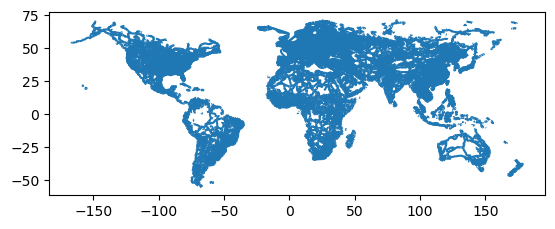

In [17]:
roads.plot()

You may have already noticed that the `roads` data is not in the same CRS as the `alaska` polygons, so these geo-datasets shound’t interact until they’re in the same CRS. Before jumping right into reprojecting and clipping, we will subset the data to select only US roads:

<Axes: >

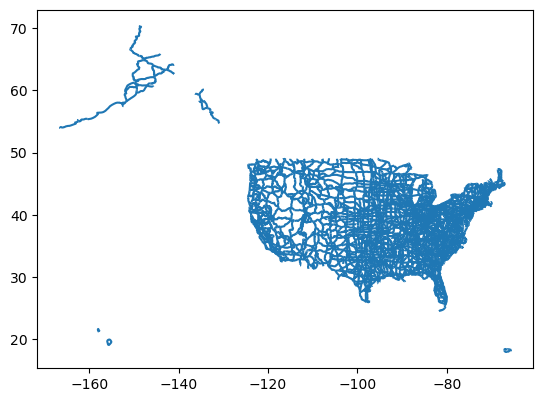

In [18]:
usa_roads = roads[roads.sov_a3 == 'USA']
usa_roads.plot()

We will now compose functions to clip `usa_roads` using the `alaska` multipolygon. Notice we are using the ouput of `usa_roads.to_crs(alaska.crs)` directly and thus not changing the `usa_roads` geo-dataframe or creating new variables:

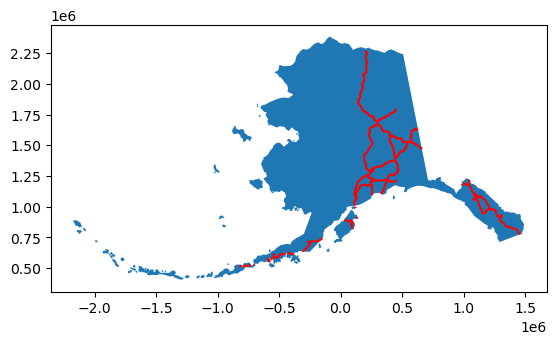

In [19]:
# Clip usa_roads to alaska geometry
ak_roads = gpd.clip(usa_roads.to_crs(alaska.crs), alaska)


fig, ax = plt.subplots()
alaska.plot(ax=ax)
ak_roads.plot(ax=ax, color='red')
plt.show()

Notice how the lines break on the small islands? However, in the `usa_roads` there are no broken lines. This should make us suspect we are leaving data out and clipping *exactly* to the polygons in `alaska` is not quite what we want.

## Clipping with a bounding box
We will clip the `usa_roads` geo-dataframe with the bounding box of `alaska` instead of its polygons. To create a bounding box, we first use the box() function we imported from `shapely.geometry`. The syntax for `box()` is:

`box(minx, miny, maxx, maxy)`

the output is a polygon representing a box constructed like this:

![Image adapted from: National Ecological Observatory Network (NEON)](bounding-box.png)

If we want to create a `shapely` polygon from the bounds of a geo-dataframe `gdf`, a more straightforward syntax is:

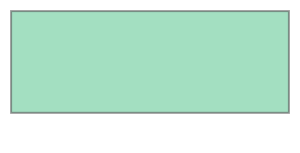

In [20]:
box(*gdf.total_bounds)

In our case:

<class 'shapely.geometry.polygon.Polygon'>


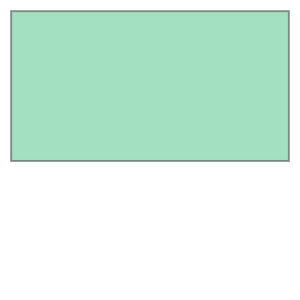

In [21]:
bbox = box(*alaska.total_bounds)
print(type(bbox))
bbox

>In the last syntax we used the asterisk * as an `unpacking operator` on the array alaska.total_bounds. Think about it as unpacking the elements of `alaska.total_bounds` and assigning them one-by-one to the paremeters `minx, miny, maxx, maxy` of the `box()` function.

>This is a good article explaining more about unpacking with * in Python: https://geekflare.com/python-unpacking-operators/

Notice that the bounding box is not a geodataframe, it is a stand alone, abstract polygon without any geospatial information. To interpret this polygon as something on the Earth’s surface we need to wrap it into a geo-datfrane abd assign it a CRS:


In [22]:
# Create geo-dataframe from bounding box
ak_bbox = gpd.GeoDataFrame(geometry = [bbox],  # Assign geometry column
                           crs = alaska.crs)  # Assign CRS
print(type(ak_bbox))
ak_bbox

<class 'geopandas.geodataframe.GeoDataFrame'>


,geometry
0,"POLYGON ((1493082.309 404545.108, 1493082.309 ..."


We can now clip the roads using Alaska’s bounding box:

In [23]:
ak_complete_roads = gpd.clip(usa_roads.to_crs(ak_bbox.crs), ak_bbox)

Notice the difference between the two clipping methods:

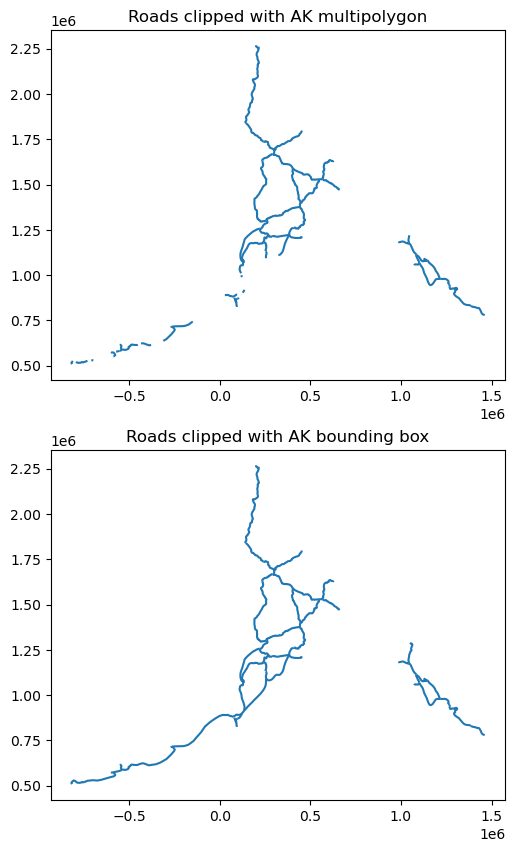

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

ak_roads.plot(ax=ax1)
ax1.set_title('Roads clipped with AK multipolygon')

ak_complete_roads.plot(ax=ax2)
ax2.set_title('Roads clipped with AK bounding box')

plt.show()

## Plot
Finally, we can put all our data together in the same map

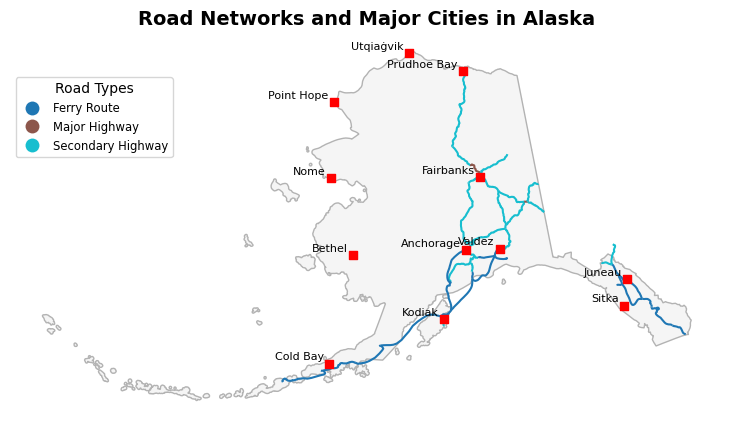

In [25]:
fig, ax = plt.subplots(figsize=(11,5))
ax.axis('off')

alaska.plot(ax=ax, color='whitesmoke', edgecolor='0.7')

ak_complete_roads.plot(ax=ax, 
                       zorder=1,  # Specify layer plotting order
                       column='type', 
                       legend=True,
                       legend_kwds={'title': "Road Types", 
                                    'loc': 'upper left',
                                    'bbox_to_anchor':(0,0.9),
                                    'fontsize':'small'}
                                    )

ak_places.plot(ax=ax, 
               zorder=2,  # Specify layer plotting order
               color='red', 
               marker='s'  # Square marker
               )
# Add city names as text annotations
for x, y, name in zip(ak_places.geometry.x, ak_places.geometry.y, ak_places['name']):
    ax.text(x-30000, y+20000, name, fontsize=8, ha='right')

ax.set_title("Road Networks and Major Cities in Alaska", fontsize=14, fontweight='bold')

plt.show()